## Task Overview

**Data**: Each entry is a fixed-size sequence of values, generated from the same distribution
 
 **Objective**: Predict the T next values given the previous S values of the seqeunce 

In [1]:
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import multiprocessing

import tensorflow as tf
from tensorflow import data
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'seq-model-01'

SEQUENCE_LENGTH = 20
INPUT_SEQUENCE_LENGTH = 16
OUTPUT_SEQUENCE_LENGTH = SEQUENCE_LENGTH - INPUT_SEQUENCE_LENGTH

TRAIN_DATA_SIZE = 1000 # sequences (entries)
TEST_DATA_SIZE = 100

TRAIN_DATA_FILE = 'data/seq01.train.csv'
TEST_DATA_FILE = 'data/seq01.test.csv'

RESUME_TRAINING = False
MULTI_THREADING = True

## Generate Sequence Data

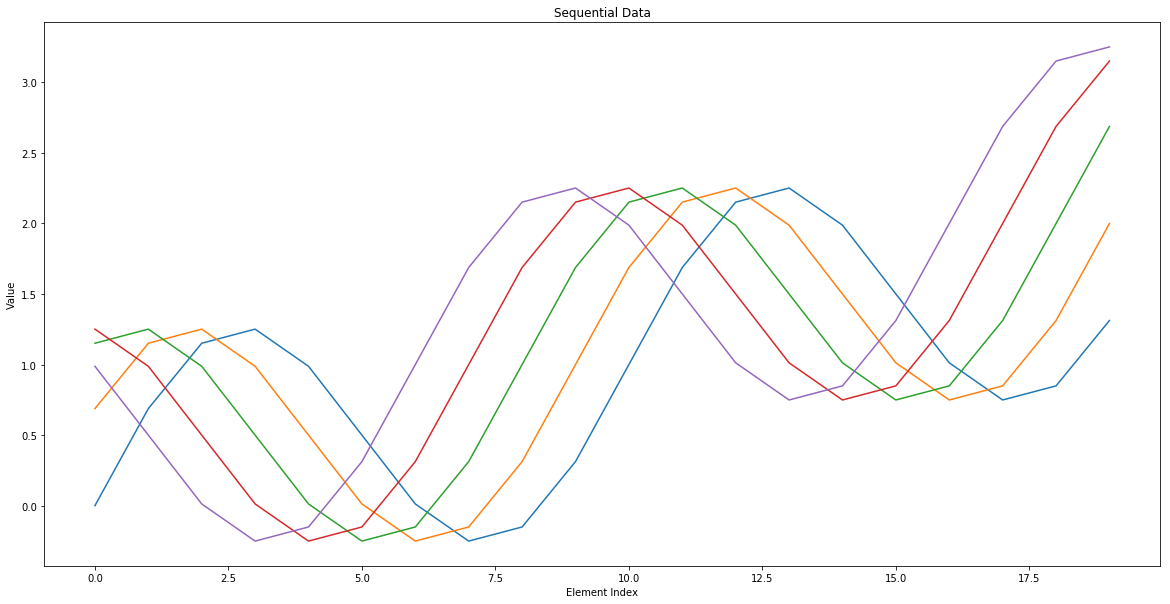

In [3]:
NOISE_RANGE = 0.0
TREND = 10.
OSCILIATION = 5.
np.random.seed = 19831006

def create_sequence(start_value):

    x =  np.array(range(start_value, start_value+SEQUENCE_LENGTH))
    noise = np.random.normal(0, NOISE_RANGE, SEQUENCE_LENGTH)
    y = np.sin(np.pi * x / OSCILIATION) + (x / TREND + noise)
    return y

plt.close('all')
plt.figure(figsize=(20, 10))

plt.subplot(1,1,1)
plt.title("Sequential Data")

for i in range(0, 5):
    
    x = range(SEQUENCE_LENGTH)
    y = create_sequence(i)
    plt.plot(x,y)

plt.xlabel("Element Index")
plt.ylabel("Value")
plt.show()

In [4]:
def to_csv(filename, N):
    with open(filename, 'w') as file_writer:
        for line_index in range(0, N):
            sequence = create_sequence(line_index)
            csv_line = ",".join(map(str, sequence))
            file_writer.write(csv_line + '\n')

to_csv(TRAIN_DATA_FILE, TRAIN_DATA_SIZE)  # 1000 sequences
to_csv(TEST_DATA_FILE,  TEST_DATA_SIZE)

In [5]:
pd.read_csv(TRAIN_DATA_FILE,header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.687785,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215
1,0.687785,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000
2,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785
3,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785,3.151057
4,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785,3.151057,3.251057


## 1. Define Dataset Metadata

In [6]:
DEFAULTS = [[0.0] for i in range(0, SEQUENCE_LENGTH)]
VALUES_FEATURE_NAME = 'values'

## 2. Define Data Input Function

In [7]:
def parse_csv_row(csv_row):
    
    # sequence is a list of tensors
    sequence = tf.decode_csv(tf.expand_dims(csv_row, -1), record_defaults=DEFAULTS)  
    
    input_sequence = sequence[ :INPUT_SEQUENCE_LENGTH]  # input elements in the sequence
    output_sequence = sequence[INPUT_SEQUENCE_LENGTH: ] # output elements in the sequence
    
    input_sequence_tensor = tf.concat(input_sequence, axis=1)
    output_sequence_tensor = tf.concat(output_sequence, axis=1)
    
    return {VALUES_FEATURE_NAME: input_sequence_tensor}, output_sequence_tensor

In [8]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=1, 
                 batch_size=20):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row), 
                          num_parallel_calls=num_threads)
    
    #dataset = dataset.batch(batch_size) #??? very long time
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, target

In [9]:
features, target = csv_input_fn(files_name_pattern="")
print("Features in CSV: {}".format(features))
print("Target in CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 20
Epoch Count: 1
Mode: eval
Shuffle: False

Features in CSV: {'values': <tf.Tensor 'IteratorGetNext:0' shape=(?, 16) dtype=float32>}
Target in CSV: Tensor("IteratorGetNext:1", shape=(?, 4), dtype=float32)


## 3. Define RNN Model Function

In [10]:
def rnn_model_fn(features, labels, mode, params):
    
    # 0. Reformat input shape to become a sequence
    inputs = tf.split(features[VALUES_FEATURE_NAME], INPUT_SEQUENCE_LENGTH, 1)
    print('inputs={}'.format(inputs))
    
    # 1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(
        num_units=params.hidden_units, 
        forget_bias=params.forget_bias,
        activation=tf.nn.tanh
    )

    
    outputs, _ = rnn.static_rnn(cell=lstm_cell, 
                                inputs=inputs, 
                                dtype=tf.float32)
    
    # slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    print('last outputs={}'.format(outputs))
    
    # output is result of linear activation of last layer of RNN
#     weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
#     bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
#     predictions = tf.matmul(outputs, weight) + bias
    
    predictions = tf.layers.dense(inputs=outputs,
                                  units=OUTPUT_SEQUENCE_LENGTH,
                                  activation=None)
    
    predict_output = {'values': predictions}
    
    if mode == tf.estimator.ModeKeys.PREDICT:

        export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(predict_output)
            }

        return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=predict_output,
                export_outputs=export_outputs)


    # Calculate loss using mean squared error
    loss = tf.losses.mean_squared_error(labels, predictions)

    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels, predictions),
        "mae": tf.metrics.mean_absolute_error(labels, predictions)
    }

    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)

    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=rnn_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 5. Run Experiment

### a. Set HParam and RunConfig

In [11]:
NUM_EPOCHS = 10000
BATCH_SIZE = 100
EVAL_AFTER_SEC = 15
TOTAL_STEPS = (TRAIN_DATA_SIZE/BATCH_SIZE)*NUM_EPOCHS

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    hidden_units=20,
    forget_bias=1.0,
    learning_rate=0.01,
    max_steps = TOTAL_STEPS
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig(
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_DATA_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_DATA_SIZE/BATCH_SIZE)
print("Total Steps:", TOTAL_STEPS)
print("That is 1 evaluation step after each",EVAL_AFTER_SEC," training seconds")

[('batch_size', 100), ('forget_bias', 1.0), ('hidden_units', 20), ('learning_rate', 0.01), ('max_steps', 100000.0), ('num_epochs', 10000)]
Model Directory: trained_models/seq-model-01

Dataset Size: 1000
Batch Size: 100
Steps per Epoch: 10.0
Total Steps: 100000.0
That is 1 evaluation step after each 15  training seconds


###  b. Define Serving Function

In [12]:
def csv_serving_input_fn():
    
    SERVING_DEFAULTS =  [[0.0] for i in range(0, INPUT_SEQUENCE_LENGTH)]

    rows_string_tensor = tf.placeholder(dtype=tf.string,
                                         shape=[None],
                                         name='csv_rows')
    
    receiver_tensor = {'csv_rows': rows_string_tensor}

    row_columns = tf.expand_dims(rows_string_tensor, -1)
    columns = tf.decode_csv(row_columns, record_defaults=SERVING_DEFAULTS)
    input_sequence_tensor = tf.concat(columns, axis=1)
    features = {VALUES_FEATURE_NAME: input_sequence_tensor}

    return tf.estimator.export.ServingInputReceiver(
        features, receiver_tensor)

### c. Define TrainSpec and EvaluSpec

In [13]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode = tf.estimator.ModeKeys.TRAIN,
        num_epochs=hparams.num_epochs,
        batch_size=hparams.batch_size
    ),
    max_steps=hparams.max_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode=tf.estimator.ModeKeys.EVAL,
        num_epochs=1,
        batch_size=hparams.batch_size,
            
    ),
    exporters=[tf.estimator.LatestExporter(
        name="forecast",  # the name of the folder in which the model will be exported to under export
        serving_input_receiver_fn=csv_serving_input_fn,
        exports_to_keep=1,
        as_text=True)],
    #throttle_secs = EVAL_AFTER_SEC,
    steps=None
)

### d. Run the experiment via tf.estimator.train_and_evaluate()

In [14]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

estimator = create_estimator(run_config, hparams)

tf.estimator.train_and_evaluate(
    estimator=estimator,
    train_spec=train_spec, 
    eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 01:52:52
.......................................
INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1243694e0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.

* data input_fn:
Input file(s): data/seq01.train.csv
Ba

INFO:tensorflow:global_step/sec: 181.526
INFO:tensorflow:loss = 0.873082, step = 6301 (0.551 sec)
INFO:tensorflow:global_step/sec: 177.659
INFO:tensorflow:loss = 0.50254, step = 6401 (0.564 sec)
INFO:tensorflow:global_step/sec: 176.342
INFO:tensorflow:loss = 0.482055, step = 6501 (0.566 sec)
INFO:tensorflow:global_step/sec: 142.463
INFO:tensorflow:loss = 0.879455, step = 6601 (0.702 sec)
INFO:tensorflow:global_step/sec: 166.846
INFO:tensorflow:loss = 0.881174, step = 6701 (0.599 sec)
INFO:tensorflow:global_step/sec: 176.399
INFO:tensorflow:loss = 0.512523, step = 6801 (0.567 sec)
INFO:tensorflow:global_step/sec: 161.15
INFO:tensorflow:loss = 0.618539, step = 6901 (0.621 sec)
INFO:tensorflow:global_step/sec: 144.943
INFO:tensorflow:loss = 1.97609, step = 7001 (0.690 sec)
INFO:tensorflow:global_step/sec: 137.111
INFO:tensorflow:loss = 0.688785, step = 7101 (0.730 sec)
INFO:tensorflow:global_step/sec: 197.312
INFO:tensorflow:loss = 1.2837, step = 7201 (0.506 sec)
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.806021, step = 14601 (0.700 sec)
INFO:tensorflow:global_step/sec: 137.25
INFO:tensorflow:loss = 0.481615, step = 14701 (0.729 sec)
INFO:tensorflow:global_step/sec: 177.47
INFO:tensorflow:loss = 0.511736, step = 14801 (0.564 sec)
INFO:tensorflow:global_step/sec: 140.27
INFO:tensorflow:loss = 0.370709, step = 14901 (0.713 sec)
INFO:tensorflow:global_step/sec: 124.167
INFO:tensorflow:loss = 0.418325, step = 15001 (0.805 sec)
INFO:tensorflow:global_step/sec: 152.833
INFO:tensorflow:loss = 0.48065, step = 15101 (0.654 sec)
INFO:tensorflow:global_step/sec: 133.715
INFO:tensorflow:loss = 1.02056, step = 15201 (0.748 sec)
INFO:tensorflow:global_step/sec: 207.674
INFO:tensorflow:loss = 0.506298, step = 15301 (0.483 sec)
INFO:tensorflow:global_step/sec: 128.532
INFO:tensorflow:loss = 0.329822, step = 15401 (0.777 sec)
INFO:tensorflow:global_step/sec: 176.54
INFO:tensorflow:loss = 0.648, step = 15501 (0.567 sec)
INFO:tensorflow:global_step/sec: 135.316
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 196.847
INFO:tensorflow:loss = 0.463931, step = 23001 (0.508 sec)
INFO:tensorflow:global_step/sec: 195.637
INFO:tensorflow:loss = 0.315958, step = 23101 (0.511 sec)
INFO:tensorflow:global_step/sec: 194.453
INFO:tensorflow:loss = 0.243662, step = 23201 (0.514 sec)
INFO:tensorflow:global_step/sec: 201.969
INFO:tensorflow:loss = 0.380099, step = 23301 (0.495 sec)
INFO:tensorflow:global_step/sec: 209.214
INFO:tensorflow:loss = 0.401121, step = 23401 (0.478 sec)
INFO:tensorflow:global_step/sec: 195.934
INFO:tensorflow:loss = 0.345509, step = 23501 (0.510 sec)
INFO:tensorflow:global_step/sec: 196.643
INFO:tensorflow:loss = 0.448689, step = 23601 (0.509 sec)
INFO:tensorflow:global_step/sec: 164.964
INFO:tensorflow:loss = 0.260328, step = 23701 (0.606 sec)
INFO:tensorflow:global_step/sec: 164.171
INFO:tensorflow:loss = 0.34964, step = 23801 (0.610 sec)
INFO:tensorflow:global_step/sec: 188.06
INFO:tensorflow:loss = 1.51041, step = 23901 (0.531 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.48203, step = 31301 (0.515 sec)
INFO:tensorflow:global_step/sec: 198.785
INFO:tensorflow:loss = 0.404314, step = 31401 (0.503 sec)
INFO:tensorflow:global_step/sec: 199.651
INFO:tensorflow:loss = 0.434007, step = 31501 (0.501 sec)
INFO:tensorflow:global_step/sec: 199.362
INFO:tensorflow:loss = 0.515082, step = 31601 (0.502 sec)
INFO:tensorflow:global_step/sec: 196.977
INFO:tensorflow:loss = 0.526697, step = 31701 (0.508 sec)
INFO:tensorflow:global_step/sec: 196.03
INFO:tensorflow:loss = 0.349023, step = 31801 (0.510 sec)
INFO:tensorflow:global_step/sec: 195.955
INFO:tensorflow:loss = 0.402516, step = 31901 (0.510 sec)
INFO:tensorflow:global_step/sec: 200.546
INFO:tensorflow:loss = 0.538956, step = 32001 (0.499 sec)
INFO:tensorflow:global_step/sec: 201.975
INFO:tensorflow:loss = 0.587139, step = 32101 (0.495 sec)
INFO:tensorflow:global_step/sec: 196.436
INFO:tensorflow:loss = 0.418498, step = 32201 (0.509 sec)
INFO:tensorflow:global_step/sec: 195.589
INFO:tensorf

INFO:tensorflow:global_step/sec: 167.159
INFO:tensorflow:loss = 0.471684, step = 39701 (0.599 sec)
INFO:tensorflow:global_step/sec: 162.665
INFO:tensorflow:loss = 0.529967, step = 39801 (0.615 sec)
INFO:tensorflow:global_step/sec: 168.36
INFO:tensorflow:loss = 0.672805, step = 39901 (0.594 sec)
INFO:tensorflow:global_step/sec: 170.321
INFO:tensorflow:loss = 3.75051, step = 40001 (0.587 sec)
INFO:tensorflow:global_step/sec: 196.251
INFO:tensorflow:loss = 0.932153, step = 40101 (0.510 sec)
INFO:tensorflow:global_step/sec: 193.871
INFO:tensorflow:loss = 0.592993, step = 40201 (0.516 sec)
INFO:tensorflow:global_step/sec: 192.542
INFO:tensorflow:loss = 0.574277, step = 40301 (0.519 sec)
INFO:tensorflow:global_step/sec: 173.315
INFO:tensorflow:loss = 0.679942, step = 40401 (0.577 sec)
INFO:tensorflow:global_step/sec: 180.948
INFO:tensorflow:loss = 1.08152, step = 40501 (0.553 sec)
INFO:tensorflow:global_step/sec: 172.876
INFO:tensorflow:loss = 1.17163, step = 40601 (0.578 sec)
INFO:tensorflo

INFO:tensorflow:loss = 0.748935, step = 48001 (0.514 sec)
INFO:tensorflow:global_step/sec: 195.136
INFO:tensorflow:loss = 0.897802, step = 48101 (0.512 sec)
INFO:tensorflow:global_step/sec: 202.753
INFO:tensorflow:loss = 0.902167, step = 48201 (0.493 sec)
INFO:tensorflow:global_step/sec: 201.593
INFO:tensorflow:loss = 0.666737, step = 48301 (0.496 sec)
INFO:tensorflow:global_step/sec: 195.415
INFO:tensorflow:loss = 0.649218, step = 48401 (0.512 sec)
INFO:tensorflow:global_step/sec: 195.501
INFO:tensorflow:loss = 0.596955, step = 48501 (0.512 sec)
INFO:tensorflow:global_step/sec: 196.095
INFO:tensorflow:loss = 0.78803, step = 48601 (0.510 sec)
INFO:tensorflow:global_step/sec: 204.982
INFO:tensorflow:loss = 0.650887, step = 48701 (0.488 sec)
INFO:tensorflow:global_step/sec: 197.546
INFO:tensorflow:loss = 0.786837, step = 48801 (0.506 sec)
INFO:tensorflow:global_step/sec: 195.146
INFO:tensorflow:loss = 0.908975, step = 48901 (0.513 sec)
INFO:tensorflow:global_step/sec: 196.86
INFO:tensorf

INFO:tensorflow:global_step/sec: 196.821
INFO:tensorflow:loss = 0.432553, step = 56401 (0.508 sec)
INFO:tensorflow:global_step/sec: 187.408
INFO:tensorflow:loss = 0.197083, step = 56501 (0.534 sec)
INFO:tensorflow:global_step/sec: 194.783
INFO:tensorflow:loss = 0.262191, step = 56601 (0.514 sec)
INFO:tensorflow:global_step/sec: 192.967
INFO:tensorflow:loss = 0.290444, step = 56701 (0.518 sec)
INFO:tensorflow:global_step/sec: 198.667
INFO:tensorflow:loss = 0.626868, step = 56801 (0.503 sec)
INFO:tensorflow:global_step/sec: 196.746
INFO:tensorflow:loss = 0.451675, step = 56901 (0.508 sec)
INFO:tensorflow:global_step/sec: 197.899
INFO:tensorflow:loss = 0.526992, step = 57001 (0.505 sec)
INFO:tensorflow:global_step/sec: 191.787
INFO:tensorflow:loss = 0.273628, step = 57101 (0.521 sec)
INFO:tensorflow:global_step/sec: 197.454
INFO:tensorflow:loss = 0.357897, step = 57201 (0.506 sec)
INFO:tensorflow:global_step/sec: 187.29
INFO:tensorflow:loss = 0.457248, step = 57301 (0.534 sec)
INFO:tensor

INFO:tensorflow:loss = 0.241717, step = 64701 (0.758 sec)
INFO:tensorflow:global_step/sec: 142.961
INFO:tensorflow:loss = 0.166461, step = 64801 (0.699 sec)
INFO:tensorflow:global_step/sec: 179.171
INFO:tensorflow:loss = 0.239643, step = 64901 (0.558 sec)
INFO:tensorflow:global_step/sec: 164.085
INFO:tensorflow:loss = 0.343782, step = 65001 (0.609 sec)
INFO:tensorflow:global_step/sec: 147.983
INFO:tensorflow:loss = 0.330624, step = 65101 (0.676 sec)
INFO:tensorflow:global_step/sec: 185.868
INFO:tensorflow:loss = 0.335912, step = 65201 (0.538 sec)
INFO:tensorflow:global_step/sec: 178.554
INFO:tensorflow:loss = 0.15179, step = 65301 (0.560 sec)
INFO:tensorflow:global_step/sec: 163.325
INFO:tensorflow:loss = 0.164695, step = 65401 (0.612 sec)
INFO:tensorflow:global_step/sec: 174.821
INFO:tensorflow:loss = 0.217639, step = 65501 (0.572 sec)
INFO:tensorflow:global_step/sec: 188.093
INFO:tensorflow:loss = 0.230048, step = 65601 (0.532 sec)
INFO:tensorflow:global_step/sec: 172.588
INFO:tensor

INFO:tensorflow:global_step/sec: 192.059
INFO:tensorflow:loss = 0.75148, step = 73101 (0.521 sec)
INFO:tensorflow:global_step/sec: 187.5
INFO:tensorflow:loss = 0.93849, step = 73201 (0.533 sec)
INFO:tensorflow:global_step/sec: 126.009
INFO:tensorflow:loss = 0.776589, step = 73301 (0.795 sec)
INFO:tensorflow:global_step/sec: 136.897
INFO:tensorflow:loss = 0.721637, step = 73401 (0.730 sec)
INFO:tensorflow:global_step/sec: 187.786
INFO:tensorflow:loss = 0.79662, step = 73501 (0.532 sec)
INFO:tensorflow:global_step/sec: 197.932
INFO:tensorflow:loss = 0.762852, step = 73601 (0.505 sec)
INFO:tensorflow:global_step/sec: 201.827
INFO:tensorflow:loss = 0.896297, step = 73701 (0.495 sec)
INFO:tensorflow:global_step/sec: 160.812
INFO:tensorflow:loss = 0.698049, step = 73801 (0.622 sec)
INFO:tensorflow:global_step/sec: 184.878
INFO:tensorflow:loss = 0.707894, step = 73901 (0.541 sec)
INFO:tensorflow:global_step/sec: 158.764
INFO:tensorflow:loss = 0.759556, step = 74001 (0.630 sec)
INFO:tensorflow

INFO:tensorflow:loss = 1.03937, step = 81401 (0.502 sec)
INFO:tensorflow:global_step/sec: 185.215
INFO:tensorflow:loss = 1.01135, step = 81501 (0.540 sec)
INFO:tensorflow:global_step/sec: 193.299
INFO:tensorflow:loss = 0.849202, step = 81601 (0.517 sec)
INFO:tensorflow:global_step/sec: 205.058
INFO:tensorflow:loss = 1.04445, step = 81701 (0.488 sec)
INFO:tensorflow:global_step/sec: 197.926
INFO:tensorflow:loss = 1.18534, step = 81801 (0.505 sec)
INFO:tensorflow:global_step/sec: 209.802
INFO:tensorflow:loss = 0.733335, step = 81901 (0.476 sec)
INFO:tensorflow:global_step/sec: 208.595
INFO:tensorflow:loss = 1.05068, step = 82001 (0.479 sec)
INFO:tensorflow:global_step/sec: 190.423
INFO:tensorflow:loss = 0.987502, step = 82101 (0.526 sec)
INFO:tensorflow:global_step/sec: 190.525
INFO:tensorflow:loss = 0.967994, step = 82201 (0.524 sec)
INFO:tensorflow:global_step/sec: 191.429
INFO:tensorflow:loss = 0.845087, step = 82301 (0.522 sec)
INFO:tensorflow:global_step/sec: 164.703
INFO:tensorflow

INFO:tensorflow:global_step/sec: 147.39
INFO:tensorflow:loss = 0.463977, step = 89801 (0.678 sec)
INFO:tensorflow:global_step/sec: 147.039
INFO:tensorflow:loss = 4.11118, step = 89901 (0.680 sec)
INFO:tensorflow:global_step/sec: 125.663
INFO:tensorflow:loss = 0.359656, step = 90001 (0.795 sec)
INFO:tensorflow:global_step/sec: 144.886
INFO:tensorflow:loss = 0.41695, step = 90101 (0.690 sec)
INFO:tensorflow:global_step/sec: 160.007
INFO:tensorflow:loss = 0.664883, step = 90201 (0.625 sec)
INFO:tensorflow:global_step/sec: 165.752
INFO:tensorflow:loss = 0.520073, step = 90301 (0.603 sec)
INFO:tensorflow:global_step/sec: 188.76
INFO:tensorflow:loss = 0.506322, step = 90401 (0.530 sec)
INFO:tensorflow:global_step/sec: 145.364
INFO:tensorflow:loss = 0.749157, step = 90501 (0.688 sec)
INFO:tensorflow:global_step/sec: 179.216
INFO:tensorflow:loss = 0.536439, step = 90601 (0.558 sec)
INFO:tensorflow:global_step/sec: 154.176
INFO:tensorflow:loss = 0.561854, step = 90701 (0.649 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 170.75
INFO:tensorflow:loss = 0.53079, step = 98101 (0.586 sec)
INFO:tensorflow:global_step/sec: 186.956
INFO:tensorflow:loss = 0.386465, step = 98201 (0.535 sec)
INFO:tensorflow:global_step/sec: 157.922
INFO:tensorflow:loss = 0.501428, step = 98301 (0.633 sec)
INFO:tensorflow:global_step/sec: 170.364
INFO:tensorflow:loss = 0.445157, step = 98401 (0.587 sec)
INFO:tensorflow:global_step/sec: 154.943
INFO:tensorflow:loss = 0.641967, step = 98501 (0.645 sec)
INFO:tensorflow:global_step/sec: 151.381
INFO:tensorflow:loss = 0.523871, step = 98601 (0.661 sec)
INFO:tensorflow:global_step/sec: 199.885
INFO:tensorflow:loss = 0.841542, step = 98701 (0.500 sec)
INFO:tensorflow:global_step/sec: 158.402
INFO:tensorflow:loss = 1.12022, step = 98801 (0.631 sec)
INFO:tensorflow:global_step/sec: 183.034
INFO:tensorflow:loss = 0.413079, step = 98901 (0.547 sec)
INFO:tensorflow:global_step/sec: 171.141
INFO:tensorflow:loss = 0.5861, step = 99001 (0.584 sec)
INFO:tensorflow

In [15]:
train_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TRAIN_DATA_SIZE)

test_input_fn = lambda: csv_input_fn(files_name_pattern= TEST_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TEST_DATA_SIZE)

estimator = create_estimator(run_config, hparams)

train_results = estimator.evaluate(input_fn=train_input_fn, steps=1)
train_rmse = str(train_results["rmse"])
print()
print("######################################################################################")
print("# Train RMSE: {} - {}".format(train_rmse, train_results))
print("######################################################################################")

test_results = estimator.evaluate(input_fn=test_input_fn, steps=1)
test_rmse = str(test_results["rmse"])
print()
print("######################################################################################")
print("# Test RMSE: {} - {}".format(test_rmse, test_results))
print("######################################################################################")

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1243694e0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/seq01.train.csv
Batch size: 1000
Epoch Count: 1
Mode: eval
Shuffle: False

inputs=[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, 

## 6. Prediction

In [22]:
import itertools

LEN = 500

predict_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.PREDICT,
                                      batch_size=TRAIN_DATA_SIZE)

predictions = list(itertools.islice(estimator.predict(input_fn=predict_input_fn),LEN))
prediction_outputs = list(map(lambda item: list(item["values"]),predictions[:3]))
print()
print("Predicted Values: {}".format(prediction_outputs))


* data input_fn:
Input file(s): data/seq01.train.csv
Batch size: 1000
Epoch Count: 1
Mode: infer
Shuffle: False

inputs=[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:10' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:11' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:12' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:13' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:14' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:15' shape=(?, 1) dtype=float32>]
last outputs=Tensor("rnn/rnn/basic_lstm_cell/mul_47:0", shape=(?, 20), d

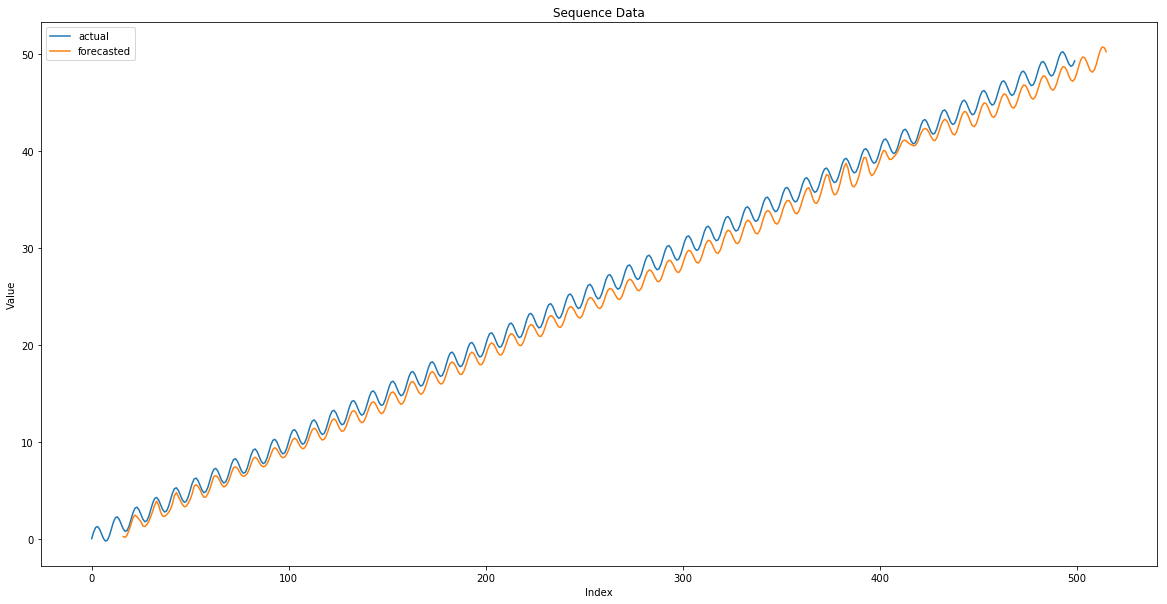

In [23]:
x =  np.array(range(0, LEN))
noise = np.random.normal(0, NOISE_RANGE, LEN)
actual_values = np.sin(np.pi * x / OSCILIATION) + (x / TREND + noise)
forecasted_values = list(map(lambda item: list(item["values"])[0],predictions))



plt.close('all')
plt.figure(figsize=(20, 10))
plt.title("Sequence Data")
plt.plot(x, actual_values, label='actual')
plt.plot(x+INPUT_SEQUENCE_LENGTH, forecasted_values, label='forecasted')
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

## 7. Serving the Exported Model

In [21]:
import os

export_dir = model_dir +"/export/forecast"

saved_model_dir = export_dir + "/" + os.listdir(path=export_dir)[-1] 

print(saved_model_dir)

predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = saved_model_dir,
    signature_def_key="predictions"
)

output = predictor_fn({'csv_rows': ['1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4']})
print(output)

trained_models/seq-model-01/export/forecast/1511834550
INFO:tensorflow:Restoring parameters from b'trained_models/seq-model-01/export/forecast/1511834550/variables/variables'
{'values': array([[ 2.52802086,  2.07758141,  1.97408485,  2.25787354]], dtype=float32)}
